In [ ]:
!pip install dmba
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools
from statsmodels.tsa.holtwinters import ExponentialSmoothing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 22.9 MB/s eta 0:00:00


# Introduction
For my Capstone project, I have prepared a forecasting model to predict day to day sales of merchandise in the hobbies department of Walmart in the state of California. For this analysis, I have used the knowledge that I learned in Chapters 16, 17, and 18 about time series, and time series forecast in order to prepare a model to predict day to day sales. Before starting on this notebook, I "trimmed" my data, in the attached "MyWalmartData" Jupyter Notebook. In doing so, I took my dataset and reshaped the dataframe, from having a column for each day, to having a column for day number, which allowed me to create a time series from the quantity sold and day columns of data.

# Exploratory Data Analysis
To begin this project, I will take my newly trimmed data from myWalmartData and create an initial time series from that data.

(0.0, 1100.0)

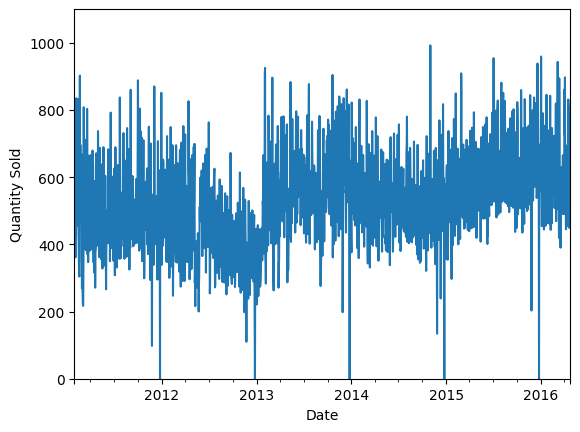

In [ ]:
# Load in dataset
Walmart_df = pd.read_csv("myWalmartData-2.csv")

# Converts date information from 'date' column to a datetime object
Walmart_df['date'] = pd.to_datetime(Walmart_df['date'], format='%Y-%m-%d')

# Converts qty.sld column to the time series
quantitysold_ts = pd.Series(Walmart_df.qty_sld.values, index=Walmart_df.date, name='Quantity Sold')

# Defines the time series frequency
quantitysold_ts.index = pd.DatetimeIndex(quantitysold_ts.index, freq=quantitysold_ts.index.inferred_freq)

# Plots the series
ax = quantitysold_ts.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Quantity Sold')
ax.set_ylim(0, 1100)

My inital reaction from this plot is there are far too many data points in order to do an analysis, for this time series. To complete an analysis of this data, I am going to take a slice of the data from the first six months of 2015, and create a time series from that data.

(0.0, 1100.0)

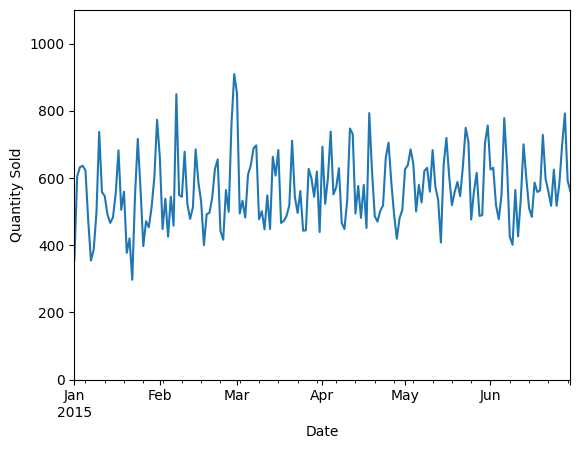

In [ ]:
# takes a slice of quantitysold data, in the first 6 months of 2015
quantitysold2015_ts = quantitysold_ts['2015':'2015-6']

# plots the new time series
ax = quantitysold2015_ts.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Quantity Sold')
ax.set_ylim(0,1100)

After examining this new time series, I ruled out the use of a linear regression model in order to forecast predictions of this time series. It is pretty clear to me off the bat that this not a linear trend, not an exponential trend, and not a polynomial trend. I am going to attempt to use smoothing methods to build a model. My first attempts to build a model I will include below. I was trying to achieve a trend with seasonality, and I was pretty close to what I wanted to achieve, but at first my parameters were not set correctly.

In [ ]:
# The following set of code is from figure 17.2 in the textbook, and will help me build the graph layout
# from the textbook in order to show my data split into training and validation sets.
def singleGraphLayout(ax, ylim, train_df, valid_df):
    ax.set_xlim('2015', '2015-7')
    ax.set_ylim(*ylim)
    ax.set_xlabel('Day')
    one_month = pd.Timedelta('31 days')
    xtrain = (min(train_df.index), max(train_df.index) - one_month)
    xvalid = (min(valid_df.index) + one_month, max(valid_df.index) - one_month)
    xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])

    ypos = 0.9 * ylim[1] + 0.1 * ylim[0]
    ax.add_line(plt.Line2D(xtrain, (ypos, ypos), color='black', linewidth=0.5))
    ax.add_line(plt.Line2D(xvalid, (ypos, ypos), color='black', linewidth=0.5))
    ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)

    ypos = 0.925 * ylim[1] + 0.075 * ylim[0]
    ax.text('2015-3', ypos, 'Training')
    ax.text('2015-6', ypos, 'Validation')
# This code creates two graphs, one that displays the data, and one that displays forecast errors
def graphLayout(axes, train_df, valid_df):
    singleGraphLayout(axes[0], [0, 1100], train_df, valid_df)
    singleGraphLayout(axes[1], [-550,550], train_df, valid_df)
    train_df.plot(y='Quantity Sold', ax=axes[0], color='C0', linewidth=0.75)
    valid_df.plot(y='Quantity Sold', ax=axes[0], color='C0', linestyle='dashed', linewidth=0.75)
    axes[1].axhline(y=0, xmin=0, xmax=1, color='black', linewidth=0.5)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Quantity Sold')
    axes[1].set_ylabel('Forecast Errors')
    if axes[0].get_legend():
        axes[0].get_legend().remove

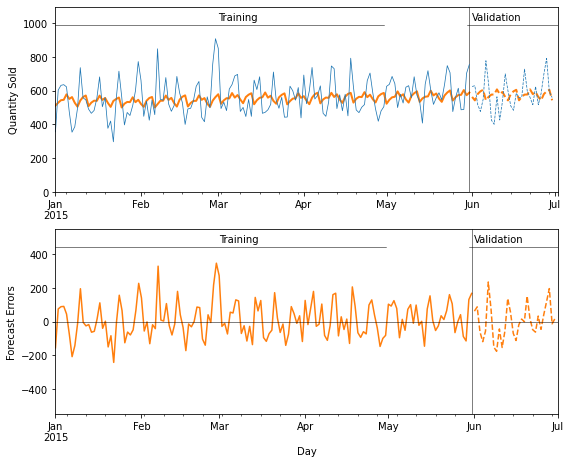

In [ ]:
# This is my first attempt to create a smoothing model with seasonality that is pretty much a carbon
# copy of the model built in Chapter 18, with no adjustments.
nValid = 30
nTrain = len(quantitysold2015_ts) - nValid

train_ts = quantitysold2015_ts[:nTrain]
valid_ts = quantitysold2015_ts[nTrain:]
expSmooth = ExponentialSmoothing(train_ts, seasonal='additive', seasonal_periods=12, freq='D')
expSmoothFit = expSmooth.fit()
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))
expSmoothFit.fittedvalues.plot(ax=axes[0], linewidth=2, color='C1')
expSmoothFit.forecast(len(valid_ts)).plot(ax=axes[0], linewidth=2, color='C1',
                                          linestyle='dashed')
residual = train_ts - expSmoothFit.fittedvalues
residual.plot(ax=axes[1], color='C1')
residual = valid_ts - expSmoothFit.forecast(len(valid_ts))
residual.plot(ax=axes[1], color='C1', linestyle='dashed')
graphLayout(axes, train_ts, valid_ts)

The results that I get from this model are pretty satisfying, but I would like to se if I could fine tune the parameters to minimize the forecast error. In my next attmept, I will change the nValid to 60 in order to give a bit more of the data to the validation set, as well as change the number of seasonal patterns to 120, one for each day in the forecast, just to see the effect.

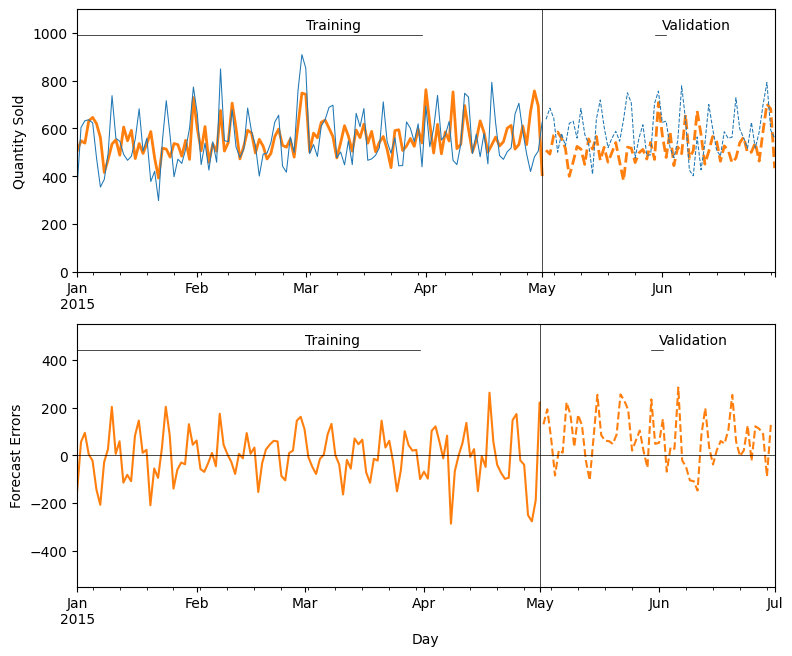

In [ ]:
# In this model, I change nValid to 60
nValid = 60
nTrain = len(quantitysold2015_ts) - nValid

train_ts = quantitysold2015_ts[:nTrain]
valid_ts = quantitysold2015_ts[nTrain:]
# I also changed seasonal periods to 120
expSmooth = ExponentialSmoothing(train_ts, seasonal='additive', seasonal_periods=60, freq='D')
expSmoothFit = expSmooth.fit()
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))
expSmoothFit.fittedvalues.plot(ax=axes[0], linewidth=2, color='C1')
expSmoothFit.forecast(len(valid_ts)).plot(ax=axes[0], linewidth=2, color='C1',
                                          linestyle='dashed')
residual = train_ts - expSmoothFit.fittedvalues
residual.plot(ax=axes[1], color='C1')
residual = valid_ts - expSmoothFit.forecast(len(valid_ts))
residual.plot(ax=axes[1], color='C1', linestyle='dashed')
graphLayout(axes, train_ts, valid_ts)

This model was actually quite effective for forecast values, but there was a lot of random error in the validation set of data, and I would like to be able to create a model that better controls that error.

# Model Construction
After some consideration, I decided to test a new type of seasonality in my model, weekly seasonality. When thinking of the retail market, it would make sense that each day of each week sees similar sales numbers for this item. I changed the number of seasonal periods in my model to 7, one for each day of the week, and I was very pleased with the results.

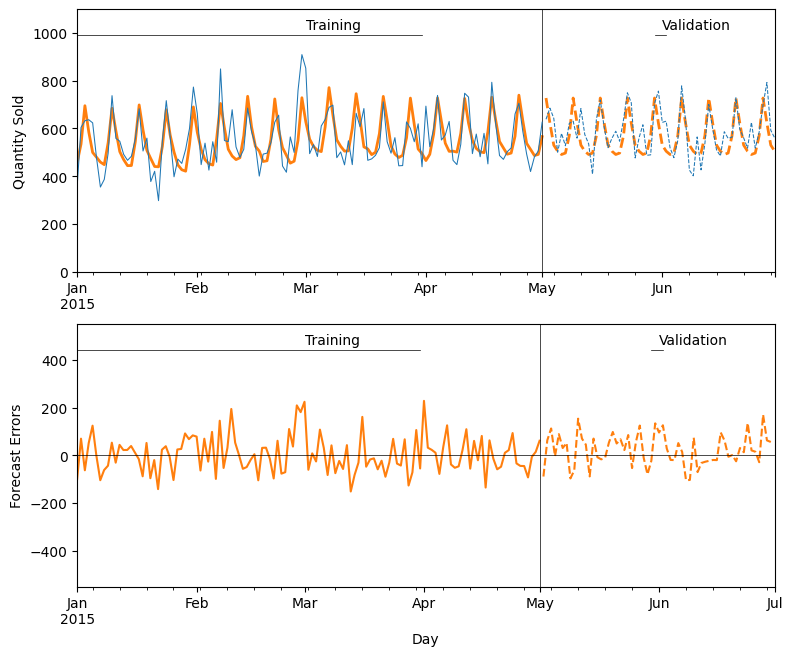

In [ ]:
# I continued with nValid = 60, as I liked the 60 day validation period from my previous model
nValid = 60
nTrain = len(quantitysold2015_ts) - nValid

train_ts = quantitysold2015_ts[:nTrain]
valid_ts = quantitysold2015_ts[nTrain:]
# Here we create the exponential smoothing function, setting seasonal periods equal to 7.
expSmooth = ExponentialSmoothing(train_ts, seasonal='additive', seasonal_periods=7, freq='D')
expSmoothFit = expSmooth.fit()
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))
expSmoothFit.fittedvalues.plot(ax=axes[0], linewidth=2, color='C1')
expSmoothFit.forecast(len(valid_ts)).plot(ax=axes[0], linewidth=2, color='C1',
                                          linestyle='dashed')
residual = train_ts - expSmoothFit.fittedvalues
residual.plot(ax=axes[1], color='C1')
residual = valid_ts - expSmoothFit.forecast(len(valid_ts))
residual.plot(ax=axes[1], color='C1', linestyle='dashed')
graphLayout(axes, train_ts, valid_ts)

This model builds a forecast that I am very proud of. As you can see from the residual plot, error is very controlled in this model, which is the goal I was trying to achieve. This model shows that there is weekly seasonality in this data.

# Conclusion
I am very pleased with the results that I got from this model. As you can see in the forecast errors graph, the error that this model produces is very controlled compared to the other two models that I created earlier. It appears that every value the model has forecasted has predicted the quantiy sold within 200 units, where other models were frequently outside this range. In order to improve this model, more factors about sales could be included. This current model only includes factors from the first 7 days of sales for the year, so a holiday, such as Easter or Memorial Day, could have a significant impact on quantity sold that this model is not equipped to forecast. That being said, this model has helped me prove that there is weekly seasonality in the hobbies department sales of Walmarts in California. The experience that I have had building this project and learning how to read, build and interpret time series has been a beneficial experience for me as a student, and I believe it gives me knowledge I could apply in a real world scenario a few years down the road in a professional position, when looking for trends and seasonality in data.